In [1]:
import sys
sys.path.append('/vera/u/olwitt/illustris_python/illustris_python')
from loadMPBs import loadMPBs

import time
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import h5py
import numba as nb
from numba import jit, njit
import tracerFuncs as tF
import insituFuncs as iF

plt.style.use('default')
plt.rcParams["figure.figsize"][0] = 16
plt.rcParams["figure.figsize"][1] = 9
plt.rcParams['errorbar.capsize']=2

In [2]:
basePath='/virgotng/universe/IllustrisTNG/TNG50-4/output'
h_const=il.groupcat.loadHeader(basePath,99)['HubbleParam']
boxSize = il.groupcat.loadHeader(basePath,99)['BoxSize']
print(h_const)

0.6774


# where is tracer parent?

find out, where the tracer parent sits, i.e. whether it's still in the main progenitor or in another galaxy or in the IGM

In [194]:
def location_of_parents(parent_index_filename, basePath, start_snap, target_snap):
    """first output returns the subhalo index if the tracer parent particle sits in a galaxy or -1 if it's in the IGM
    second output states, whether parent particle is inside main progenitor at target snapshot"""
    start = time.time()
    #load file
    index_file = h5py.File(parent_index_filename,'r')
    parent_indices = index_file['parent_indices'][:,:]
    
    location = np.empty(parent_indices[:,0].shape,dtype=int)
    location.fill(-1)
    
    f = h5py.File(basePath[:-6] + 'postprocessing/offsets/offsets_0' + str(target_snap) + '.hdf5','r')
    starsInSubOffset = f['Subhalo/SnapByType'][:,4]
    gasInSubOffset = f['Subhalo/SnapByType'][:,0]
    f.close()
    
    
    #load number of particles per galaxy to avoid classifying parents as bound to a galaxy 
    #while they're in reality "inner fuzz"
    #of a halo
    num_in_sub = il.groupcat.loadSubhalos(basePath, target_snap, fields = ['SubhaloLenType'])
    gas_num_in_sub = num_in_sub[:,0].copy()
    star_num_in_sub = num_in_sub[:,4].copy()
    
    del num_in_sub
    end_load = time.time()
    #print('time for loading: ',end_load-start)
    
    #find parent index in offset files in NlogM
    which = parent_indices[:,1]
    indices = parent_indices[:,0]     
    for i in nb.prange(parent_indices[:,0].shape[0]):
        if which[i] == 0: #gas parent
            ind = np.searchsorted(gasInSubOffset,indices[i],'right')
            ind-=1 #compensate for how np.searchsorted chooses the index
            
            #only important for last galaxy of halo: check whether particle is inner fuzz, i.e. IGM particles
            if gasInSubOffset[ind] + gas_num_in_sub[ind] < indices[i]:
                continue
            
        else: #star parent
            ind = np.searchsorted(starsInSubOffset,indices[i],'right')
            ind-=1 #compensate for how np.searchsorted chooses the index
            
            #only important for last galaxy of halo: check whether particle is inner fuzz, i.e. IGM particles
            if starsInSubOffset[ind] + star_num_in_sub[ind] < indices[i]:
                continue
                
        location[i]=ind
    
    end_loc = time.time()
    #print('time for locating: ',end_loc - end_load)
    
    #now identify parents that are still in their (main progenitor) galaxy
    
    g = h5py.File(basePath[:-6] + 'postprocessing/offsets/offsets_0' + str(start_snap) + '.hdf5','r')
    starsInSubOffset_start_snap = g['Subhalo/SnapByType'][:,4]
    starsInGroupOffset = g['Group/SnapByType'][:,4]
    g.close()
    numStarsInSubs_start_snap = il.groupcat.loadSubhalos(basePath, start_snap, fields = ['SubhaloLenType'])[:,4]
    
    #########################################problem with fuzz???##########################################
    #calculate _inSitu_ star offsets again
    check = h5py.File(basePath[:-6] + 'postprocessing/StellarAssembly/stars_0' + str(start_snap) + '.hdf5','r')
    insitu = check['InSitu'][:] #1 if star is formed insitu and 0 otherwise
    check.close()
    
    insituStarsInSubOffset = np.zeros(starsInSubOffset_start_snap.shape[0])
    insituStarsInGroupOffset = np.zeros(starsInGroupOffset.shape[0])
    for i in range(1,starsInSubOffset_start_snap.shape[0]):
        star_indices = np.arange(starsInSubOffset_start_snap[i-1],starsInSubOffset_start_snap[i-1] +\
                                 numStarsInSubs_start_snap[i-1])
        star_indices2 = np.arange(starsInGroupOffset[i-1],starsInGroupOffset[i])
        insitu_indices = insitu[star_indices]
        insitu_indices2 = insitu[star_indices2]
        insituStarsInSubOffset[i] = len(np.nonzero(insitu_indices)[0])
        insituStarsInGroupOffset[i] = len(np.nonzero(insitu_indices2)[0])
    
    insituStarsInSubOffset = np.cumsum(insituStarsInSubOffset)
    insituStarsInGroupOffset = np.cumsum(insituStarsInGroupOffset)
    
    tracersInParentsOffsets = index_file['tracers_in_parents_offset'][:].copy()
    parentsInSubOffset = tF.tracersInSubhalo(insituStarsInSubOffset,tracersInParentsOffsets).astype(int)
    parentsInGroupOffset = tF.tracersInSubhalo(insituStarsInGroupOffset,tracersInParentsOffsets).astype(int)
    
    parentsInSubOffset = np.insert(parentsInSubOffset,0,0)
    ######################################################################################################
    
    end_insitu = time.time()
    #print('time for insitu offsets: ',end_insitu - end_loc)
    
    numSubs = il.groupcat.loadSubhalos(basePath,start_snap,fields=['SubhaloPos']).shape
    ids = np.arange(numSubs[0])

    #load all MPBs
    tree_ids = loadMPBs(basePath,start_snap,ids=ids, fields=['SubfindID'])
    end_loadMPBs = time.time()
    #print('time for loading MPBs: ',end_loadMPBs - end_loc)
    
    isInMP = np.empty(parent_indices[:,0].shape,dtype=bool)
    isInMP.fill(False)
    tree_check = list(tree_ids)
    
    #determine missing trees:
    missing = []
    counter = 0
    for i in range(parentsInSubOffset.shape[0]-1):
        if i != tree_check[counter]:
            missing.append(i)
            i+=1
            continue
        counter+=1
        
    end_check = time.time()        
    #print('time for checking trees: ',end_check - end_loadMPBs)
    
    test = 0
    for j in nb.prange(0,parentsInSubOffset.shape[0]-1): #loop over all galaxies at z=0
        #find all associated particles:
        ParentIndicesInSub = np.arange(parentsInSubOffset[j],parentsInSubOffset[j+1])
        
        if j in missing or ParentIndicesInSub.size == 0: #if subhalo hast no tree, skip it and assign "False"
            if j in missing:
                test+=ParentIndicesInSub.size
            continue
        if tree_ids[j]['SubfindID'].shape[0] <= start_snap - target_snap: #if tree doesn't reach until target_snap
            test+=ParentIndicesInSub.size            
            continue
        main_prog = tree_ids[j]['SubfindID'][start_snap - target_snap]
        where = np.where(location[ParentIndicesInSub] == main_prog)[0] + ParentIndicesInSub[0]
        isInMP[where] = True
        
    end = time.time()
    #print('time for checking MPs: ',end - end_check)
    print('total time: ',end-start)
    print('problems: ',test)
    index_file.close()
    return location, isInMP

In [187]:
location, isInMP, missing = location_of_parents('files/TNG50-4/parent_indices_redshift_0.0.hdf5',\
                                       basePath, start_snap = 99, target_snap = 99)

time for loading:  0.06595778465270996
time for locating:  6.703874349594116
number insitu stars:  (380022,)
insitu stars in subhalo offset:  [    0.  8330. 10451. 11331. 12581. 14664. 14862. 15655. 16405. 17189.]
insitu stars in halo offset:  [    0. 26359. 41040. 48294. 59596. 72362. 79405. 86351. 89816. 93099.]
number insitu stars:  380022.0
parents in subhalo offset:  [51811 51829]
parents in halo offset:  [18799 29336 34625 42876 52055 57123 62094 64594 66944 71306]
time for insitu offsets:  0.25353240966796875
time for loading MPBs:  1.6299772262573242
time for checking trees:  0.006703615188598633
time for checking MPs:  0.09926033020019531
total time:  8.505773305892944
problems:  693


In [189]:
print(np.where(isInMP==True)[0].shape) #all insitu stars should be in their MP at z=0
print(np.where(isInMP==False)[0].shape)
print(np.where(location==-1)[0].shape) #no insitu star can be outside of its galaxy at z=0 -> result correct
print(np.where(location!=-1)[0].shape)

(274847,)
(693,)
(0,)
(275540,)


In [129]:
print(tF.is_sorted_increasing(location))
print(np.where(location==2)[0].size)

True
1499


In [195]:
z = np.array([0,0.2,0.5,0.7,1.0,2.0,3.0,4.0,5.0])
snap = np.array([99,84,67,59,50,33,25,21,17])

mp = np.zeros(9)
igm = np.zeros(9)
sub = np.zeros(9)
for i in range(9):
    location, isInMP = location_of_parents('files/TNG50-4/parent_indices_redshift_' + str(z[i]) + '.hdf5',\
                                       basePath, start_snap = 99, target_snap = snap[i])
    mp[i] = np.where(isInMP==True)[0].shape[0]
    igm[i] = np.where(location==-1)[0].shape[0]
    sub[i] = np.where(location!=-1)[0].shape[0]

#mp = np.array([180879,176578,171665,164996,156488,108415,65584,36212,19019])
#igm = np.array([0,232,3222,8272,20173,80367,140952,187490,220715])
#sub = np.array([275540,275308,272318,267268,255367,194903,134588,88050,54825])
total = np.zeros(9)
for i in range(9):
    total[i] = igm[i] + sub[i]

total time:  8.22029423713684
problems:  693
total time:  7.398478746414185
problems:  1733
total time:  7.7908103466033936
problems:  1736
total time:  8.083760499954224
problems:  1736
total time:  7.690999984741211
problems:  1736
total time:  8.303667545318604
problems:  1741
total time:  7.857044219970703
problems:  2761
total time:  6.990115165710449
problems:  3446
total time:  5.823934078216553
problems:  7110


Text(0.5, 1.0, 'tracer fraction in MP / other galaxies / IGM')

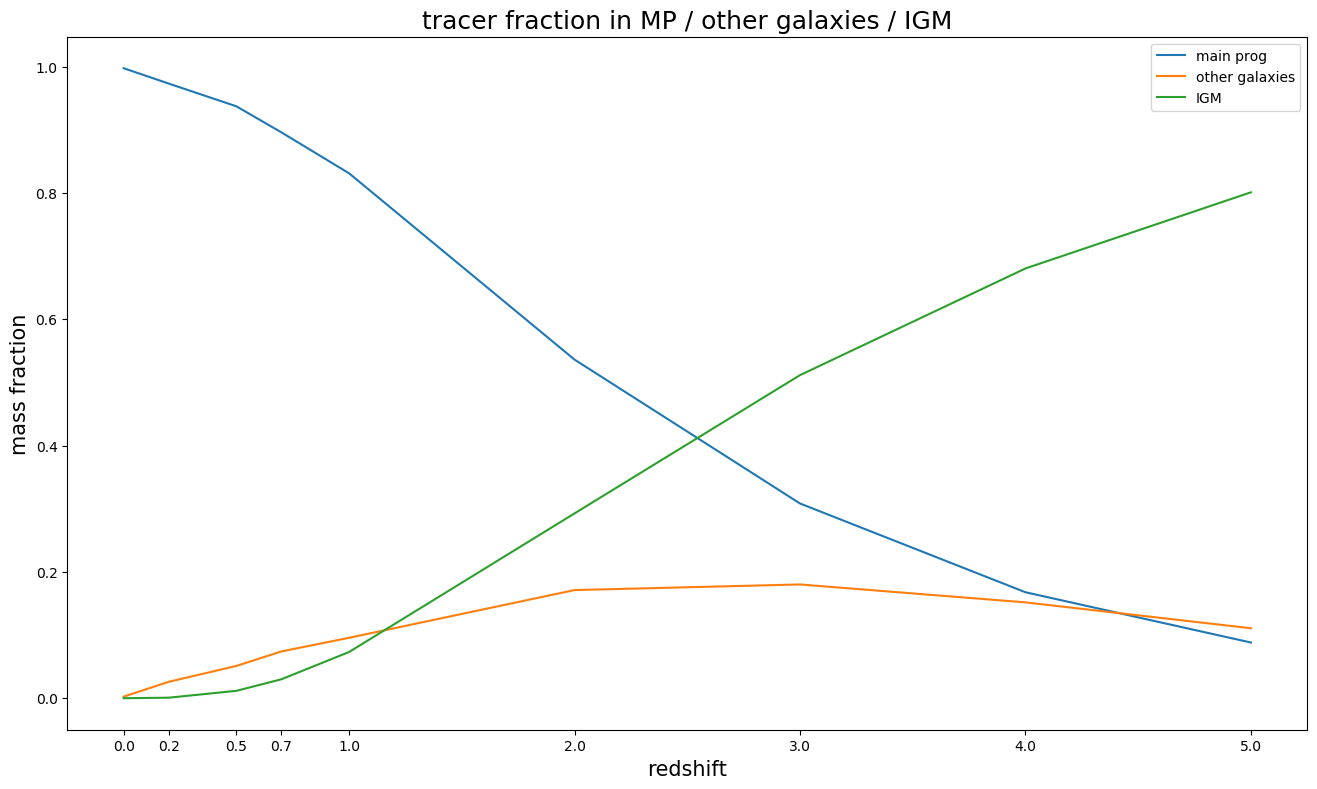

In [198]:
plt.plot(z, mp/total, label = 'main prog')
plt.plot(z, (sub - mp)/total, label = 'other galaxies')
plt.plot(z, igm/total, label = 'IGM')
plt.legend()
plt.ylabel('mass fraction',size=15)
plt.xlabel('redshift',size=15)
plt.xticks(z)
plt.title('tracer fraction in MP / other galaxies / IGM',size=18)
#plt.savefig('pics/tracer_fraction.jpg',format='jpg')

In [134]:
index_file = h5py.File('files/TNG50-4/parent_indices_redshift_0.0.hdf5','r')
tracers_in_parent_offset = index_file['tracers_in_parents_offset'][:]
index_file.close()

print(sum(tracers_in_parent_offset[:10451]))

7434.0


In [155]:
spec_id = 185